# Micro Leakage Tracker - Hidden Cost Dsocovery

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import calendar
import warnings
warnings.filterwarnings('ignore')

sns.set(style='whitegrid', palette='muted', font_scale=1.1)

In [2]:
df = pd.read_csv("corrected_personal_spending_dataset.csv")

print("Shape of dataset:", df.shape)
df.head(5)

Shape of dataset: (1091, 12)


,Id,Date,type,category,value,Is_Necessary,payment_mode,is_recurring,context,time_block,day_type,cummulative monthly spend
0,1,01-01-2023,expense,Education,1217,Yes,Debit Card,No,Planned,Afternoon,Weekend,1217.0
1,2,01-01-2023,income,Bonus,2245,No,Credit Card,No,Unplanned,Afternoon,Weekend,NaN
2,3,01-01-2023,expense,Education,525,Yes,Debit Card,No,Planned,Morning,Weekend,1742.0
3,4,02-01-2023,expense,Entertainment,194,No,UPI,No,Unplanned,Morning,Weekday,1936.0
4,5,02-01-2023,expense,Clothing,208,No,Cash,No,Seasonal,Morning,Weekday,2144.0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1091 entries, 0 to 1090
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Id                         1091 non-null   int64  
 1   Date                       1091 non-null   object 
 2   type                       1091 non-null   object 
 3   category                   1091 non-null   object 
 4   value                      1091 non-null   int64  
 5   Is_Necessary               1091 non-null   object 
 6   payment_mode               1091 non-null   object 
 7   is_recurring               1091 non-null   object 
 8   context                    1091 non-null   object 
 9   time_block                 1091 non-null   object 
 10  day_type                   1091 non-null   object 
 11  cummulative monthly spend  860 non-null    float64
dtypes: float64(1), int64(2), object(9)
memory usage: 102.4+ KB


In [4]:
df.describe()


,Id,value,cummulative monthly spend
count,1091.000000,1091.000000,860.000000
mean,31.547204,1142.668194,21068.474419
std,18.706676,1602.087980,13715.224100
min,1.000000,21.000000,100.000000
25%,16.000000,224.000000,10289.250000
50%,31.000000,617.000000,19435.500000
75%,46.000000,1412.500000,30454.250000
max,78.000000,17158.000000,65581.000000


In [5]:
df.sample(5)

,Id,Date,type,category,value,Is_Necessary,payment_mode,is_recurring,context,time_block,day_type,cummulative monthly spend
1080,45,26-06-2024,expense,Travel,1504,No,Net Banking,No,Seasonal,Evening,Weekday,19083.0
120,43,18-02-2023,expense,Groceries,582,Yes,Debit Card,No,Routine,Evening,Weekend,28804.0
644,35,20-11-2023,income,Bonus,3775,No,Net Banking,No,Planned,Evening,Weekday,NaN
858,72,29-02-2024,expense,Medical,996,Yes,Cash,No,Emergency,Night,Weekday,35957.0
299,20,09-05-2023,expense,Groceries,748,Yes,Net Banking,No,Routine,Night,Weekday,18865.0


# DATA PREPROCESSING

In [6]:
missing_values = df.isnull().sum()
print("Missing Values per Column:\n", missing_values)

Missing Values per Column:
 Id                             0
Date                           0
type                           0
category                       0
value                          0
Is_Necessary                   0
payment_mode                   0
is_recurring                   0
context                        0
time_block                     0
day_type                       0
cummulative monthly spend    231
dtype: int64


In [7]:
missing_percent = (df.isnull().sum() / len(df)) * 100
print("\nPercentage of Missing Values:\n", missing_percent)


Percentage of Missing Values:
 Id                            0.000000
Date                          0.000000
type                          0.000000
category                      0.000000
value                         0.000000
Is_Necessary                  0.000000
payment_mode                  0.000000
is_recurring                  0.000000
context                       0.000000
time_block                    0.000000
day_type                      0.000000
cummulative monthly spend    21.173236
dtype: float64


In [8]:
print(df['Date'].head())

0    01-01-2023
1    01-01-2023
2    01-01-2023
3    02-01-2023
4    02-01-2023
Name: Date, dtype: object


In [9]:
df['Date'] = pd.to_datetime(df['Date'], format='%d-%m-%Y', errors='coerce')

In [10]:
print("Failed Date Conversions:", df['Date'].isna().sum())

Failed Date Conversions: 0


In [11]:
categorical_cols = [
    'type', 'category', 'Is_Necessary', 'payment_mode',
    'is_recurring', 'context', 'time_block', 'day_type'
]

for col in categorical_cols:
    print(f"\nColumn: {col}")
    print(df[col].value_counts(dropna=False))


Column: type
type
expense    860
income     131
savings    100
Name: count, dtype: int64

Column: category
category
Clothing             76
Dining Out           76
Groceries            71
Education            67
EMI                  65
Mobile Recharge      65
Travel               65
Utilities            62
Medical              61
Entertainment        60
Rent                 57
Subscription         55
Fuel                 52
Freelance            35
Interest             35
Bonus                32
Salary               29
Gift                 28
Stock Investment     21
Recurring Deposit    17
Fixed Deposit        17
Gold                 17
Piggy Bank           15
Mutual Fund          13
Name: count, dtype: int64

Column: Is_Necessary
Is_Necessary
No     643
Yes    448
Name: count, dtype: int64

Column: payment_mode
payment_mode
Cash           254
Debit Card     226
UPI            213
Net Banking    201
Credit Card    197
Name: count, dtype: int64

Column: is_recurring
is_recurring
No     

In [12]:
important_cols = [
    'type', 'category', 'Is_Necessary', 'value',
    'is_recurring', 'payment_mode', 'context',
    'time_block', 'day_type', 'cummulative monthly spend'
]

missing_important_cols = [col for col in important_cols if col not in df.columns]
if missing_important_cols:
    print("Missing critical columns:", missing_important_cols)
else:
    print("All key columns for segmentation are present.")


All key columns for segmentation are present.


In [13]:
duplicate_count = df.duplicated().sum()
print(f"Duplicate Rows: {duplicate_count}")

Duplicate Rows: 0


In [14]:
df = df.drop_duplicates()

In [15]:
expense_df = df[df['type'] == 'expense']

In [16]:
print("\nExpense Value Summary:")
print(expense_df['value'].describe())


Expense Value Summary:
count     860.000000
mean      877.003488
std       905.823757
min        35.000000
25%       216.000000
50%       556.500000
75%      1217.000000
max      5735.000000
Name: value, dtype: float64


In [17]:
print("\nTop Expense Categories:")
print(expense_df['category'].value_counts().head(10))


Top Expense Categories:
category
Dining Out         76
Clothing           76
Groceries          71
Education          67
EMI                65
Travel             65
Mobile Recharge    65
Utilities          62
Medical            61
Entertainment      60
Name: count, dtype: int64


## Data Cleaning

In [18]:
print(df.isnull().sum())

Id                             0
Date                           0
type                           0
category                       0
value                          0
Is_Necessary                   0
payment_mode                   0
is_recurring                   0
context                        0
time_block                     0
day_type                       0
cummulative monthly spend    231
dtype: int64


In [19]:
df['Is_Necessary'] = df.apply(
    lambda x: x['Is_Necessary'] if pd.notnull(x['Is_Necessary']) else ("Not Applicable" if x['type'] != 'expense' else np.nan),
    axis=1
)

In [20]:
print(df.isnull().sum())

Id                             0
Date                           0
type                           0
category                       0
value                          0
Is_Necessary                   0
payment_mode                   0
is_recurring                   0
context                        0
time_block                     0
day_type                       0
cummulative monthly spend    231
dtype: int64


In [21]:
categorical_fill_cols = ['payment_mode', 'context', 'time_block', 'day_type']
for col in categorical_fill_cols:
    df[col].fillna('Unknown', inplace=True)

In [22]:
df = df.dropna(subset=['cummulative monthly spend'])

In [23]:
clean_cols = ['type', 'category', 'Is_Necessary', 'payment_mode',
              'is_recurring', 'context', 'time_block', 'day_type']

for col in clean_cols:
    df[col] = df[col].astype(str).str.strip().str.title()

In [24]:
df['category'] = df['category'].replace({
    'Dining out': 'Dining Out',
    'Mobile recharge': 'Mobile Recharge',
    'Emi': 'EMI',
    'Fixed deposit': 'Fixed Deposit'
})

In [25]:
df['value'] = pd.to_numeric(df['value'], errors='coerce')
df['cummulative monthly spend'] = pd.to_numeric(df['cummulative monthly spend'], errors='coerce')


In [26]:
print(df.isnull().sum())

Id                           0
Date                         0
type                         0
category                     0
value                        0
Is_Necessary                 0
payment_mode                 0
is_recurring                 0
context                      0
time_block                   0
day_type                     0
cummulative monthly spend    0
dtype: int64


In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 860 entries, 0 to 1089
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   Id                         860 non-null    int64         
 1   Date                       860 non-null    datetime64[ns]
 2   type                       860 non-null    object        
 3   category                   860 non-null    object        
 4   value                      860 non-null    int64         
 5   Is_Necessary               860 non-null    object        
 6   payment_mode               860 non-null    object        
 7   is_recurring               860 non-null    object        
 8   context                    860 non-null    object        
 9   time_block                 860 non-null    object        
 10  day_type                   860 non-null    object        
 11  cummulative monthly spend  860 non-null    float64       
dtypes: datetime6

In [28]:
df.loc[df['type'] != 'Expense', 'Is_Necessary'] = 'Not Applicable'
df.loc[df['type'] != 'Expense', 'context'] = 'Not Applicable'

In [29]:
for col in clean_cols:
    print(f"{col} → {df[col].unique()}")

type → ['Expense']
category → ['Education' 'Entertainment' 'Clothing' 'Dining Out' 'Travel'
 'Subscription' 'Rent' 'EMI' 'Groceries' 'Mobile Recharge' 'Utilities'
 'Fuel' 'Medical' 'Gift']
Is_Necessary → ['Yes' 'No']
payment_mode → ['Debit Card' 'Upi' 'Cash' 'Net Banking' 'Credit Card']
is_recurring → ['No' 'Yes']
context → ['Planned' 'Unplanned' 'Seasonal' 'Routine' 'Emergency' 'Festive']
time_block → ['Afternoon' 'Morning' 'Night' 'Evening']
day_type → ['Weekend' 'Weekday']


In [30]:
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()

category_dict = {col: df[col].dropna().unique().tolist() for col in categorical_cols}

import pprint
pprint.pprint(category_dict)


{'Is_Necessary': ['Yes', 'No'],
 'category': ['Education',
              'Entertainment',
              'Clothing',
              'Dining Out',
              'Travel',
              'Subscription',
              'Rent',
              'EMI',
              'Groceries',
              'Mobile Recharge',
              'Utilities',
              'Fuel',
              'Medical',
              'Gift'],
 'context': ['Planned',
             'Unplanned',
             'Seasonal',
             'Routine',
             'Emergency',
             'Festive'],
 'day_type': ['Weekend', 'Weekday'],
 'is_recurring': ['No', 'Yes'],
 'payment_mode': ['Debit Card', 'Upi', 'Cash', 'Net Banking', 'Credit Card'],
 'time_block': ['Afternoon', 'Morning', 'Night', 'Evening'],
 'type': ['Expense']}


## Feature Engineering

In [31]:
df['month'] = df['Date'].dt.month
df['year'] = df['Date'].dt.year

In [32]:
df['day_of_week'] = df['Date'].dt.day_name()

In [33]:
import numpy as np

def week_of_month(dt):
    if pd.isnull(dt):  # Check for NaT or NaN
        return np.nan
    first_day = dt.replace(day=1)
    dom = dt.day
    adjusted_dom = dom + first_day.weekday()
    return int(np.ceil(adjusted_dom / 7))

# Ensure 'Date' is datetime
df['Date'] = pd.to_datetime(df['Date'], errors='coerce', dayfirst=True)

# Apply the function
df['week_of_month'] = df['Date'].apply(week_of_month)


In [34]:
df['is_salary_week'] = df['Date'].dt.day.between(1,7)

In [35]:
df['is_micro_spend'] = (df['value'] < 300).astype(int)

In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 860 entries, 0 to 1089
Data columns (total 18 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   Id                         860 non-null    int64         
 1   Date                       860 non-null    datetime64[ns]
 2   type                       860 non-null    object        
 3   category                   860 non-null    object        
 4   value                      860 non-null    int64         
 5   Is_Necessary               860 non-null    object        
 6   payment_mode               860 non-null    object        
 7   is_recurring               860 non-null    object        
 8   context                    860 non-null    object        
 9   time_block                 860 non-null    object        
 10  day_type                   860 non-null    object        
 11  cummulative monthly spend  860 non-null    float64       
 12  month       

In [37]:
df['is_leakage_potential'] = (
    ((df['Is_Necessary'] == 'No') & (df['is_recurring'] == 'Yes')) |
    (df['context'].isin(['Unplanned', 'Festive', 'Emergency']))
).astype(int)

In [38]:
df

,Id,Date,type,category,value,Is_Necessary,payment_mode,is_recurring,context,time_block,day_type,cummulative monthly spend,month,year,day_of_week,week_of_month,is_salary_week,is_micro_spend,is_leakage_potential
0,1,2023-01-01,Expense,Education,1217,Yes,Debit Card,No,Planned,Afternoon,Weekend,1217.0,1,2023,Sunday,1,True,0,0
2,3,2023-01-01,Expense,Education,525,Yes,Debit Card,No,Planned,Morning,Weekend,1742.0,1,2023,Sunday,1,True,0,0
3,4,2023-01-02,Expense,Entertainment,194,No,Upi,No,Unplanned,Morning,Weekday,1936.0,1,2023,Monday,2,True,1,1
4,5,2023-01-02,Expense,Clothing,208,No,Cash,No,Seasonal,Morning,Weekday,2144.0,1,2023,Monday,2,True,1,0
5,6,2023-01-02,Expense,Dining Out,151,No,Upi,No,Unplanned,Afternoon,Weekday,2295.0,1,2023,Monday,2,True,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1085,50,2024-06-27,Expense,Rent,2619,Yes,Debit Card,Yes,Routine,Evening,Weekday,23806.0,6,2024,Thursday,5,False,0,0
1086,51,2024-06-27,Expense,Rent,2540,Yes,Cash,Yes,Planned,Morning,Weekday,26346.0,6,2024,Thursday,5,False,0,0
1087,52,2024-06-28,Expense,Dining Out,192,No,Net Banking,No,Unplanned,Morning,Weekday,26538.0,6,2024,Friday,5,False,1,1
1088,53,2024-06-28,Expense,Travel,1217,No,Credit Card,No,Seasonal,Evening,Weekday,27755.0,6,2024,Friday,5,False,0,0


In [39]:
# Create a Year-Month column for grouping
df['year_month'] = df['Date'].dt.to_period('M')

In [40]:
# Monthly total spend (overall)
monthly_totals = df.groupby('year_month')['value'].sum().rename('monthly_total_spend')
df = df.merge(monthly_totals, on='year_month')

In [41]:
# Monthly category spend
monthly_cat = df.groupby(['year_month', 'category'])['value'].sum().rename('monthly_category_spend').reset_index()

In [42]:
# Monthly non-essential percentage
monthly_non_ess = df.groupby('year_month').apply(
    lambda x: x.loc[x['Is_Necessary']=='No', 'value'].sum() / x['value'].sum()
).rename('monthly_non_essential_pct').reset_index()

df = df.merge(monthly_non_ess, on='year_month')

In [43]:
# Average spend per time_block
avg_time_block = df.groupby('time_block')['value'].mean().rename('avg_spend_per_time_block').reset_index()
df = df.merge(avg_time_block, on='time_block')

In [44]:
# Average spend per day_type
avg_day_type = df.groupby('day_type')['value'].mean().rename('avg_spend_per_day_type').reset_index()
df = df.merge(avg_day_type, on='day_type')

In [45]:
# Cumulative monthly spend by date
df = df.sort_values(['year_month', 'Date'])
df['cumulative_monthly_spend'] = df.groupby('year_month')['value'].cumsum()

In [46]:
# Daily spend sum
daily_spend = df.groupby('Date')['value'].sum().rename('daily_spend').reset_index()
df = df.merge(daily_spend, on='Date')

In [47]:
# Category spend ratio
df = df.merge(monthly_cat, on=['year_month', 'category'])
df['category_spend_ratio'] = df['monthly_category_spend'] / df['monthly_total_spend']

In [48]:
# Recurring expense count per month
recurring_counts = df[df['is_recurring'] == 'Yes'].groupby('year_month').size().rename('recurring_expense_count').reset_index()
df = df.merge(recurring_counts, on='year_month', how='left')
df['recurring_expense_count'] = df['recurring_expense_count'].fillna(0)

In [49]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 860 entries, 0 to 859
Data columns (total 29 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   Id                         860 non-null    int64         
 1   Date                       860 non-null    datetime64[ns]
 2   type                       860 non-null    object        
 3   category                   860 non-null    object        
 4   value                      860 non-null    int64         
 5   Is_Necessary               860 non-null    object        
 6   payment_mode               860 non-null    object        
 7   is_recurring               860 non-null    object        
 8   context                    860 non-null    object        
 9   time_block                 860 non-null    object        
 10  day_type                   860 non-null    object        
 11  cummulative monthly spend  860 non-null    float64       
 12  month   

## EDA - EXPLORATORY DATA ANALYSIS

In [50]:
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()

category_dict = {col: df[col].dropna().unique().tolist() for col in categorical_cols}

import pprint
pprint.pprint(category_dict)


{'Is_Necessary': ['Yes', 'No'],
 'category': ['Education',
              'Entertainment',
              'Clothing',
              'Dining Out',
              'Travel',
              'Subscription',
              'Rent',
              'EMI',
              'Groceries',
              'Mobile Recharge',
              'Utilities',
              'Fuel',
              'Medical',
              'Gift'],
 'context': ['Planned',
             'Unplanned',
             'Seasonal',
             'Routine',
             'Emergency',
             'Festive'],
 'day_of_week': ['Sunday',
                 'Monday',
                 'Tuesday',
                 'Wednesday',
                 'Thursday',
                 'Saturday',
                 'Friday'],
 'day_type': ['Weekend', 'Weekday'],
 'is_recurring': ['No', 'Yes'],
 'payment_mode': ['Debit Card', 'Upi', 'Cash', 'Net Banking', 'Credit Card'],
 'time_block': ['Afternoon', 'Morning', 'Night', 'Evening'],
 'type': ['Expense']}


### Expense breakdown by category
Goal: See which categories dominate your expenses.

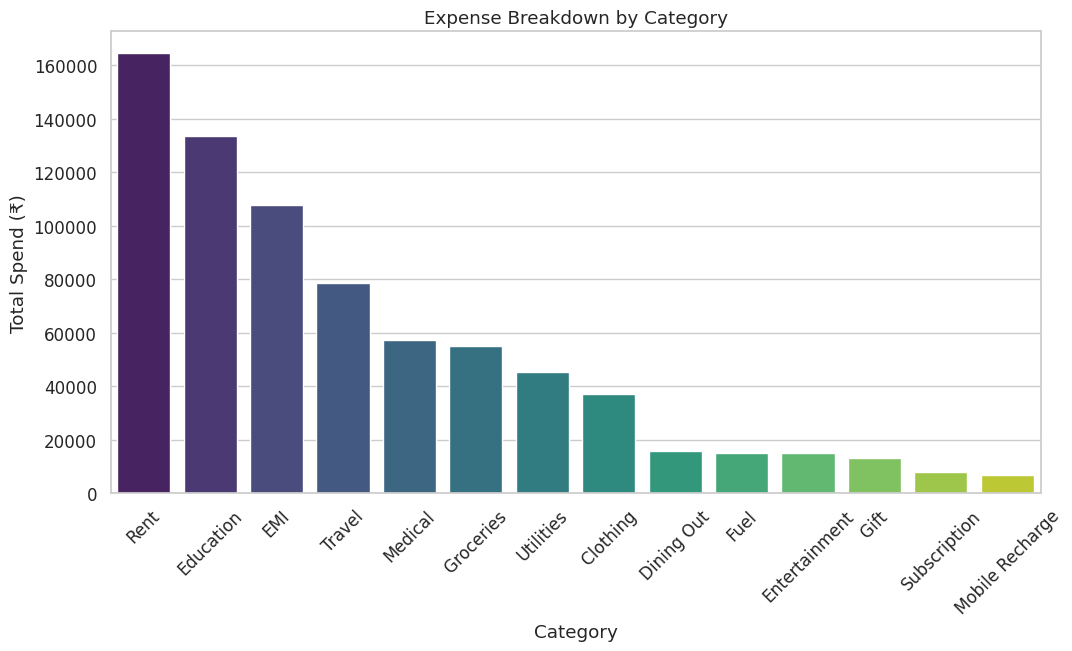

In [51]:
# Filter expenses only for clarity (should be all rows)
expense_df = df[df['type'] == 'Expense']

category_spend = expense_df.groupby('category')['value'].sum().sort_values(ascending=False)

plt.figure(figsize=(12,6))
sns.barplot(x=category_spend.index, y=category_spend.values, palette='viridis')
plt.title('Expense Breakdown by Category')
plt.xlabel('Category')
plt.ylabel('Total Spend (₹)')
plt.xticks(rotation=45)
plt.show()


### Percentage contribution of each category to total expenses

In [52]:
print(df['type'].unique())
print(df[df['type'] == 'expense'].shape)


['Expense']
(0, 29)


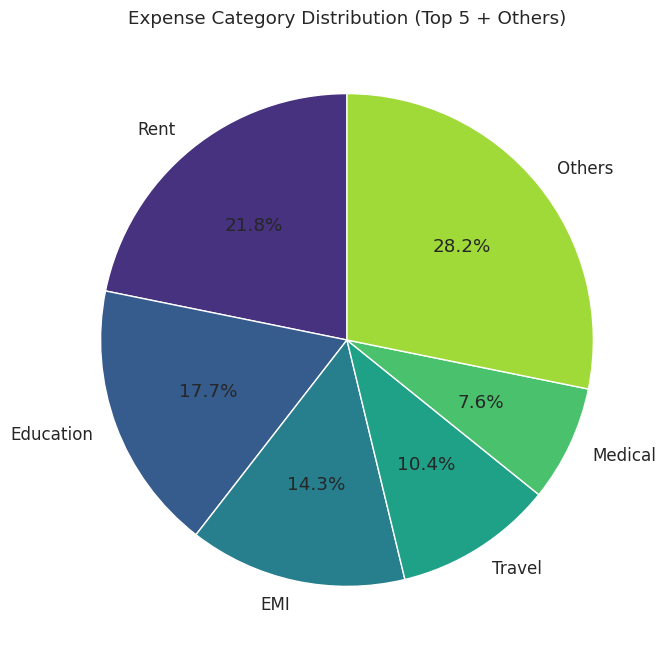

In [53]:
# Filter only expense transactions
expense_df = df[df['type'].str.lower() == 'expense']  # safer with `.str.lower()`

# Check if there's data to plot
if not expense_df.empty:
    # Group and process top 5
    category_spend = expense_df.groupby('category')['value'].sum()
    top_n = 5
    top_categories = category_spend.sort_values(ascending=False)[:top_n]
    others = category_spend.sort_values(ascending=False)[top_n:].sum()

    # Merge top and others
    category_plot_data = top_categories.copy()
    if others > 0:
        category_plot_data['Others'] = others

    # Convert to percentage
    category_pct = (category_plot_data / category_plot_data.sum()) * 100

    # Plot pie chart
    plt.figure(figsize=(8, 8))
    category_pct.plot.pie(
        autopct='%1.1f%%',
        startangle=90,
        colors=sns.color_palette('viridis', len(category_pct))
    )
    plt.title(f'Expense Category Distribution (Top {top_n} + Others)')
    plt.ylabel('')
    plt.show()
else:
    print("No 'expense' transactions found in the dataset.")


In [54]:
# Overall spend stats
overall_stats = expense_df['value'].describe()
print("Overall Spend Statistics:")
print(overall_stats)

# Per category spend stats
category_stats = expense_df.groupby('category')['value'].agg(['mean', 'median', 'std']).sort_values(by='mean', ascending=False)
print("\nSpend Statistics per Category:")
print(category_stats)


Overall Spend Statistics:
count     860.000000
mean      877.003488
std       905.823757
min        35.000000
25%       216.000000
50%       556.500000
75%      1217.000000
max      5735.000000
Name: value, dtype: float64

Spend Statistics per Category:
                        mean  median         std
category                                        
Rent             2885.842105  2683.0  966.651950
Education        1991.820896  1999.0  831.395922
EMI              1656.476923  1657.0  618.379437
Travel           1209.538462  1217.0  610.816003
Medical           940.491803   851.0  515.980608
Groceries         777.535211   706.0  344.091052
Utilities         734.709677   719.5  250.622464
Clothing          490.526316   431.0  237.298376
Gift              476.142857   477.0  264.227555
Fuel              294.115385   287.0  149.641749
Entertainment     254.083333   208.0  134.197842
Dining Out        207.565789   197.5   89.671004
Subscription      146.490909   141.0   77.667113
Mobile Rech

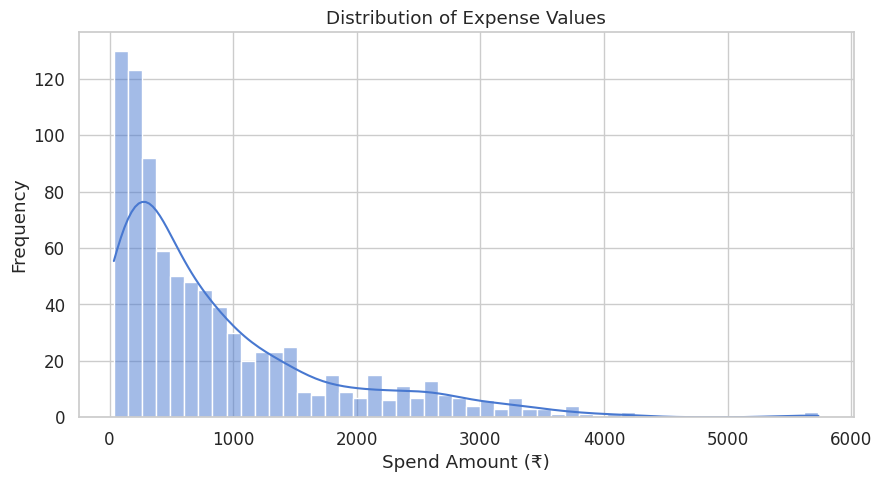

In [55]:
plt.figure(figsize=(10,5))
sns.histplot(expense_df['value'], bins=50, kde=True)
plt.title('Distribution of Expense Values')
plt.xlabel('Spend Amount (₹)')
plt.ylabel('Frequency')
plt.show()

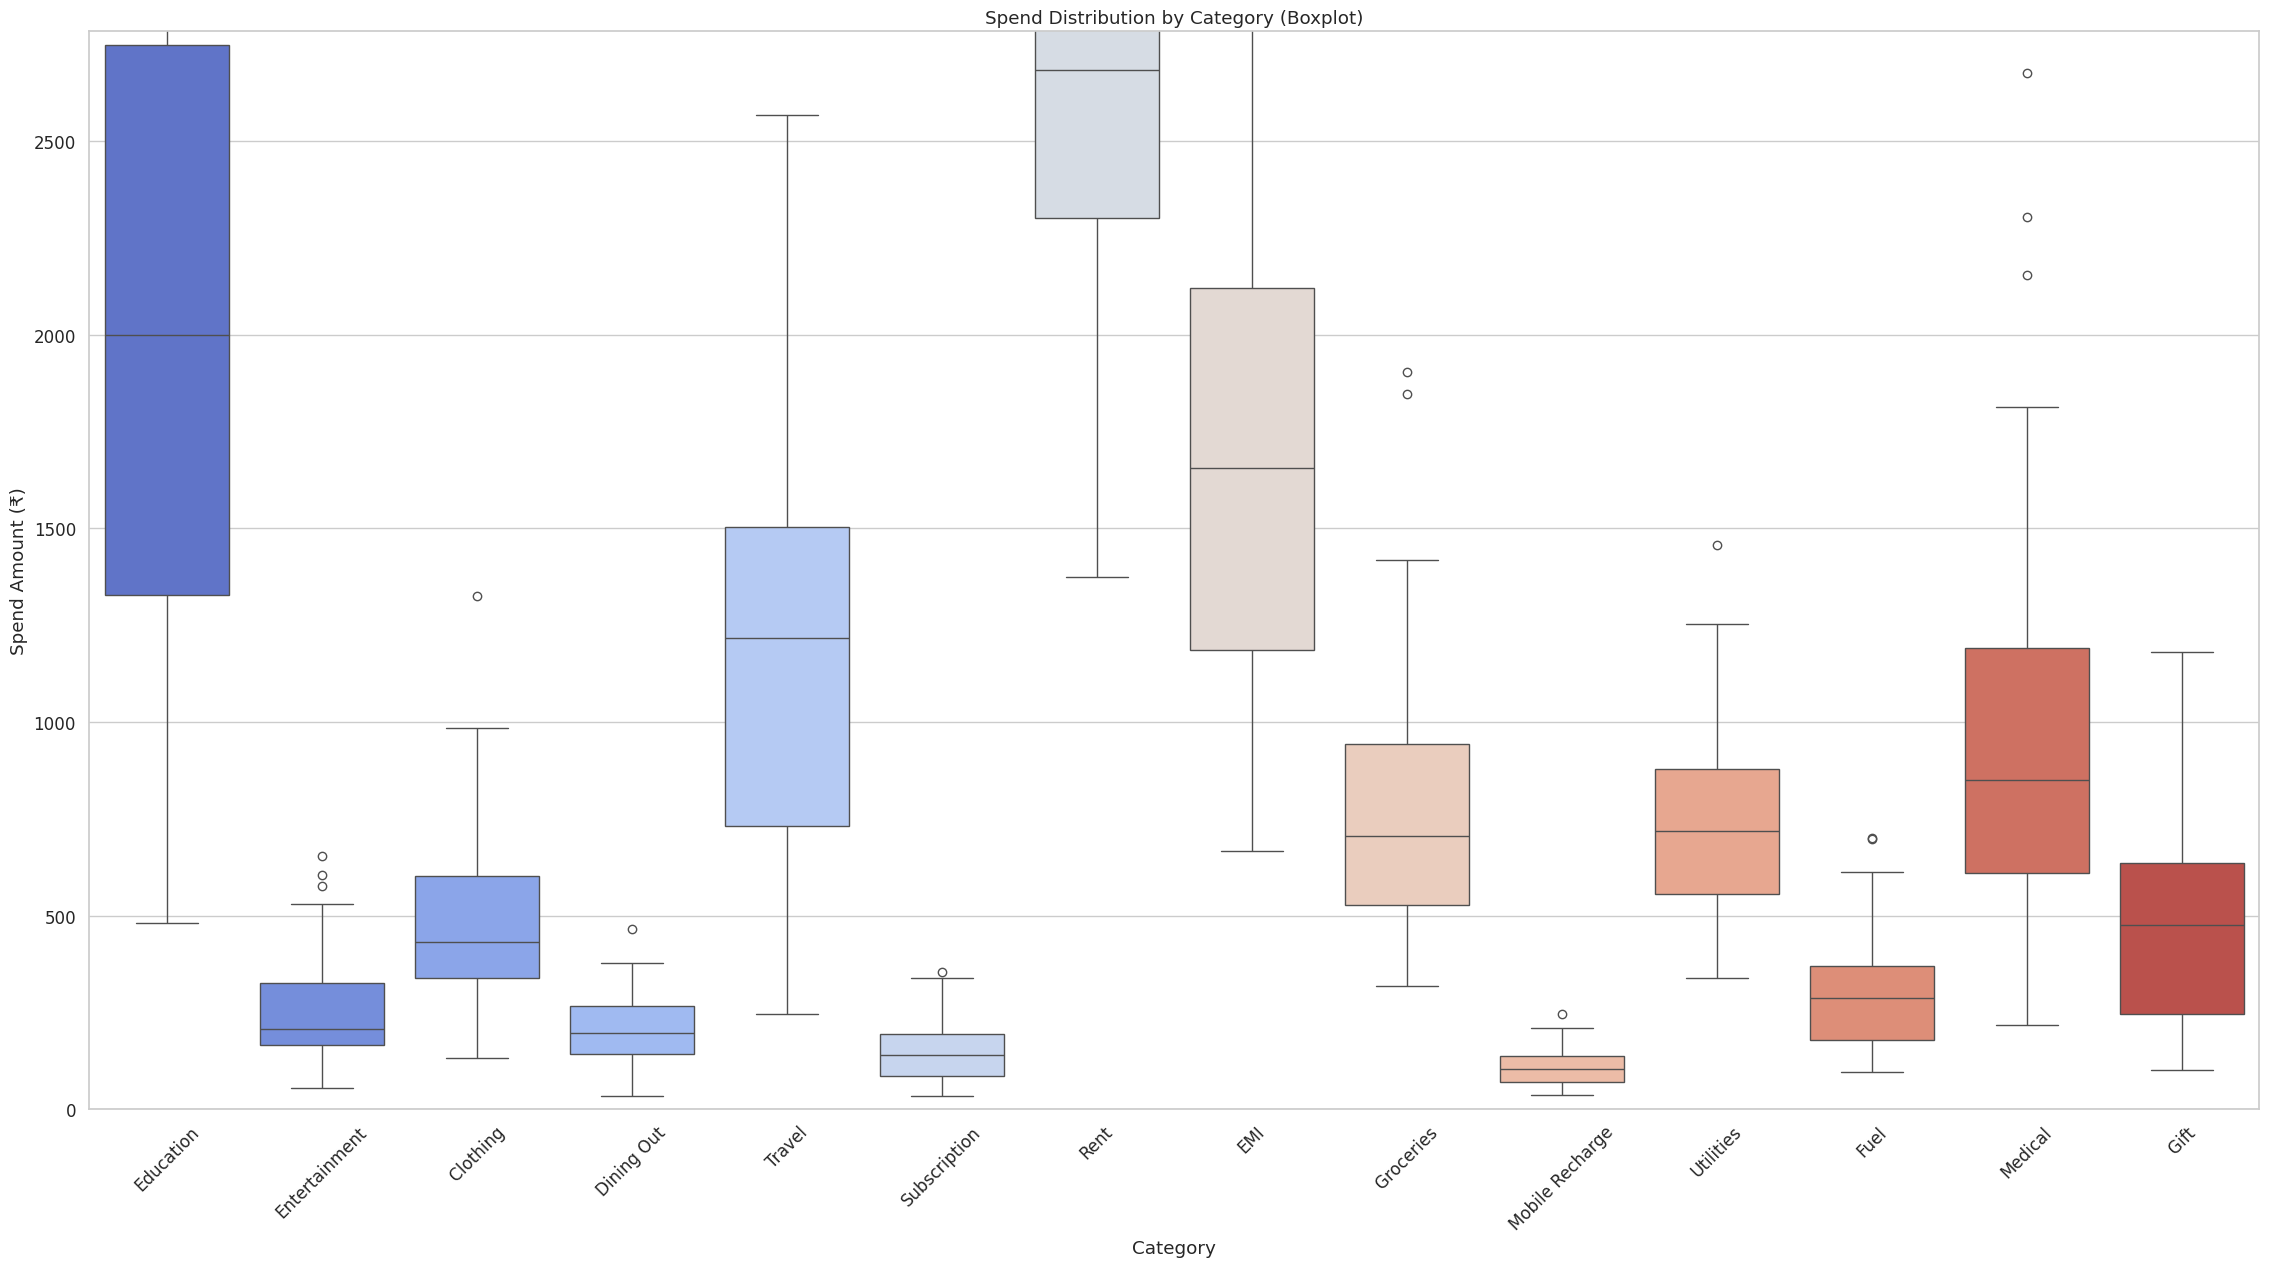

In [56]:
plt.figure(figsize=(28,14))
sns.boxplot(data=expense_df, x='category', y='value', palette='coolwarm')
plt.title('Spend Distribution by Category (Boxplot)')
plt.xlabel('Category')
plt.ylabel('Spend Amount (₹)')
plt.xticks(rotation=45)
plt.ylim(0, expense_df['value'].quantile(0.95))  # Zoom in to 95th percentile to reduce extreme outlier effect
plt.show()


#### Micro-Leakage Detection — Detailed Execution

Objective :

- Find categories/contexts with highest unnecessary or unplanned spend

- Understand micro spends (small spends <₹300) — when, where, and how they happen

- Analyze payment modes, time blocks, and day types linked to leakage

- Review subscriptions and recurring charges for leakage potential



In [57]:
# Filter leakage relevant data
leakage_filter = ( (df['Is_Necessary'] == 'No') | (df['context'].isin(['Unplanned', 'Emergency', 'Festive'])) )
leakage_df = df[leakage_filter]

# Aggregate spend by category and context
leakage_summary = leakage_df.groupby(['category', 'context']).agg(
    total_spend=('value', 'sum'),
    transaction_count=('value', 'count')
).reset_index()

# Sort by total spend descending
leakage_summary = leakage_summary.sort_values(by='total_spend', ascending=False)

print("Top categories and contexts with non-necessary or unplanned spend:")
print(leakage_summary.head(10))


Top categories and contexts with non-necessary or unplanned spend:
         category    context  total_spend  transaction_count
10         Travel   Seasonal        78620                 65
6            Rent  Unplanned        60906                 18
5         Medical  Emergency        57370                 61
0        Clothing   Seasonal        37280                 76
1      Dining Out  Unplanned        15775                 76
3            Fuel  Unplanned        15294                 52
2   Entertainment  Unplanned        15245                 60
4            Gift    Festive        13332                 28
9    Subscription  Unplanned         3311                 21
8    Subscription    Routine         2565                 17


Expense heatmap by payment_mode, time_block, day_type -

We create pivot tables for spend and transaction count, then visualize heatmaps to spot where leakages happen by payment method, time of day, and weekday/weekend.

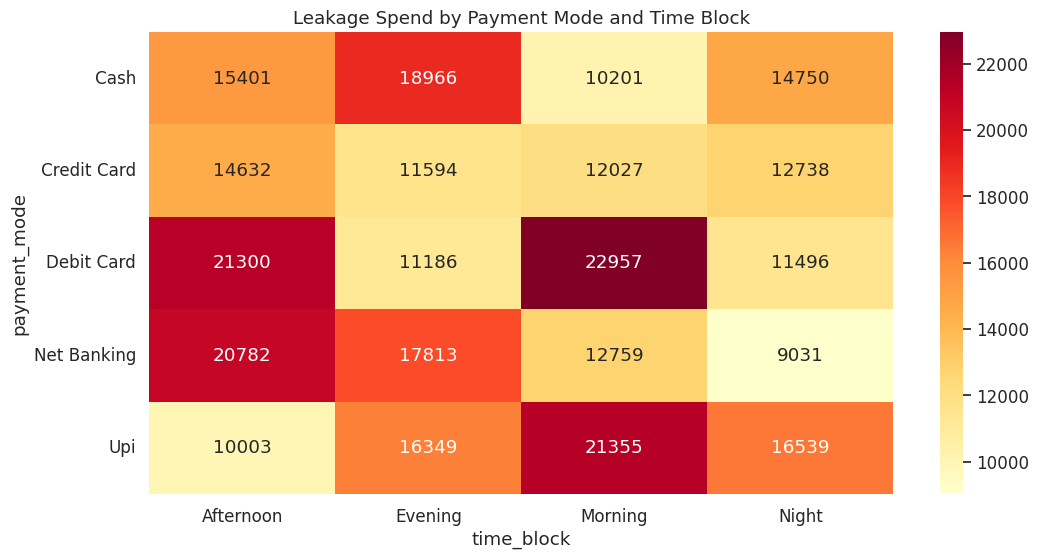

In [58]:
import matplotlib.pyplot as plt
import seaborn as sns

# Pivot tables for total spend
pivot_payment_time = leakage_df.pivot_table(
    values='value',
    index='payment_mode',
    columns='time_block',
    aggfunc='sum',
    fill_value=0
)

pivot_payment_day = leakage_df.pivot_table(
    values='value',
    index='payment_mode',
    columns='day_type',
    aggfunc='sum',
    fill_value=0
)

plt.figure(figsize=(12,6))
sns.heatmap(pivot_payment_time, annot=True, fmt=".0f", cmap='YlOrRd')
plt.title('Leakage Spend by Payment Mode and Time Block')
plt.show()



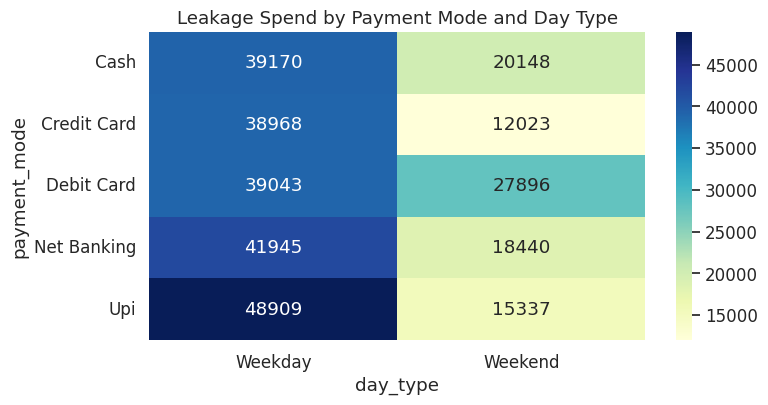

In [59]:
plt.figure(figsize=(8,4))
sns.heatmap(pivot_payment_day, annot=True, fmt=".0f", cmap='YlGnBu')
plt.title('Leakage Spend by Payment Mode and Day Type')
plt.show()


Frequency and value of micro-spends (value < ₹300) -

Count number and total value of micro-spends overall and by category/context/time_block.

In [60]:
# Filter micro spends (< ₹300)
micro_spends = df[(df['value'] < 300) & (df['type'] == 'Expense')]

# Overall micro spend count and sum
micro_count = micro_spends.shape[0]
micro_sum = micro_spends['value'].sum()
print(f"Micro-spends count: {micro_count}, Total micro-spend amount: ₹{micro_sum}")

# Breakdown by category
micro_by_cat = micro_spends.groupby('category')['value'].agg(['count', 'sum']).sort_values(by='sum', ascending=False)
print("\nMicro-spends by Category:")
print(micro_by_cat)

# Breakdown by context
micro_by_context = micro_spends.groupby('context')['value'].agg(['count', 'sum']).sort_values(by='sum', ascending=False)
print("\nMicro-spends by Context:")
print(micro_by_context)

# Breakdown by time_block
micro_by_time = micro_spends.groupby('time_block')['value'].agg(['count', 'sum']).sort_values(by='sum', ascending=False)
print("\nMicro-spends by Time Block:")
print(micro_by_time)

Micro-spends count: 282, Total micro-spend amount: ₹45217

Micro-spends by Category:
                 count    sum
category                     
Dining Out          64  11610
Entertainment       43   7925
Subscription        53   7362
Mobile Recharge     65   6877
Fuel                28   5275
Clothing            14   2875
Gift                 9   1742
Travel               3    827
Medical              3    724

Micro-spends by Context:
           count    sum
context                
Unplanned    156  28121
Routine       82   9442
Seasonal      17   3702
Festive        9   1742
Planned       15   1486
Emergency      3    724

Micro-spends by Time Block:
            count    sum
time_block              
Morning        76  13154
Night          70  10798
Evening        70  10772
Afternoon      66  10493


Subscriptions & Recurring Charges Overview -

Analyze recurring expenses flagged as leakage potential:

- Filter recurring expenses (is_recurring == 'Yes')

- Check how many are necessary vs non-necessary

- Trend monthly recurring non-necessary spend

In [61]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 860 entries, 0 to 859
Data columns (total 29 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   Id                         860 non-null    int64         
 1   Date                       860 non-null    datetime64[ns]
 2   type                       860 non-null    object        
 3   category                   860 non-null    object        
 4   value                      860 non-null    int64         
 5   Is_Necessary               860 non-null    object        
 6   payment_mode               860 non-null    object        
 7   is_recurring               860 non-null    object        
 8   context                    860 non-null    object        
 9   time_block                 860 non-null    object        
 10  day_type                   860 non-null    object        
 11  cummulative monthly spend  860 non-null    float64       
 12  month   

Recurring Expenses - Necessary vs Non-necessary:
  Is_Necessary  total_spend  transaction_count
0           No         8057                 55
1          Yes       272164                122


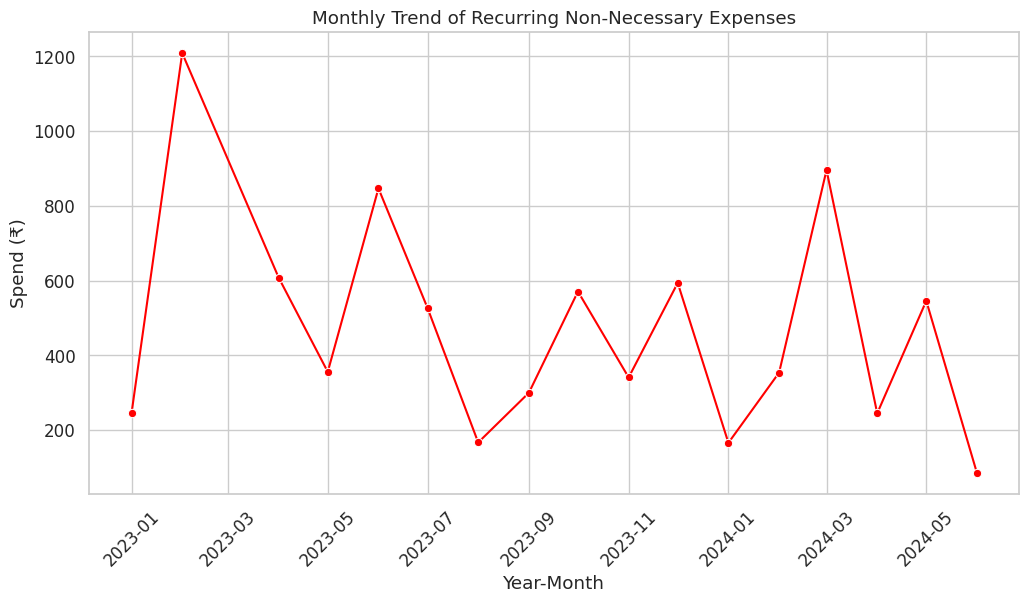

In [62]:
# Recurring expenses
recurring_expenses = df[(df['type'] == 'Expense') & (df['is_recurring'] == 'Yes')]

# Recurring necessary vs non-necessary counts and spend
recurring_summary = recurring_expenses.groupby('Is_Necessary').agg(
    total_spend=('value', 'sum'),
    transaction_count=('value', 'count')
).reset_index()

print("Recurring Expenses - Necessary vs Non-necessary:")
print(recurring_summary)

# Monthly trend of recurring non-necessary expenses
recurring_non_necessary = recurring_expenses[recurring_expenses['Is_Necessary'] == 'No']

monthly_recurring_leakage = recurring_non_necessary.groupby('year_month')['value'].sum().reset_index()

# Convert year_month period to datetime for plotting
monthly_recurring_leakage['year_month_dt'] = monthly_recurring_leakage['year_month'].dt.to_timestamp()

plt.figure(figsize=(12,6))
sns.lineplot(data=monthly_recurring_leakage, x='year_month_dt', y='value', marker='o', color='red')
plt.title('Monthly Trend of Recurring Non-Necessary Expenses')
plt.xlabel('Year-Month')
plt.ylabel('Spend (₹)')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


###Behavioral Pattern Recognition

Objectives:

- Understand how spending behavior shifts between weekends and weekdays.

- Explore spending patterns during festive months (October, December).

- Analyze spending during summer/winter holidays (periods of expected low spending).

- Detect peak spending hours and potential triggers.

- Identify leakage patterns related to time, day, and context.



1. Spending Patterns on Weekends vs Weekdays -

Goal: Compare average spend, category distribution, and leakage incidence between weekends and weekdays.

Actions:

Group data by day_type (Weekend vs Weekday).

Calculate average spend, total spend, and count of transactions.

Breakdown spending by category and leakage flags.

Spending Summary by Day Type (Weekend vs Weekday):
  day_type   avg_spend  total_spend  transaction_count  leakage_spend  \
0  Weekday  880.009934       531526                604         135347   
1  Weekend  869.910156       222697                256          50632   

   leakage_count  
0            256  
1             94  


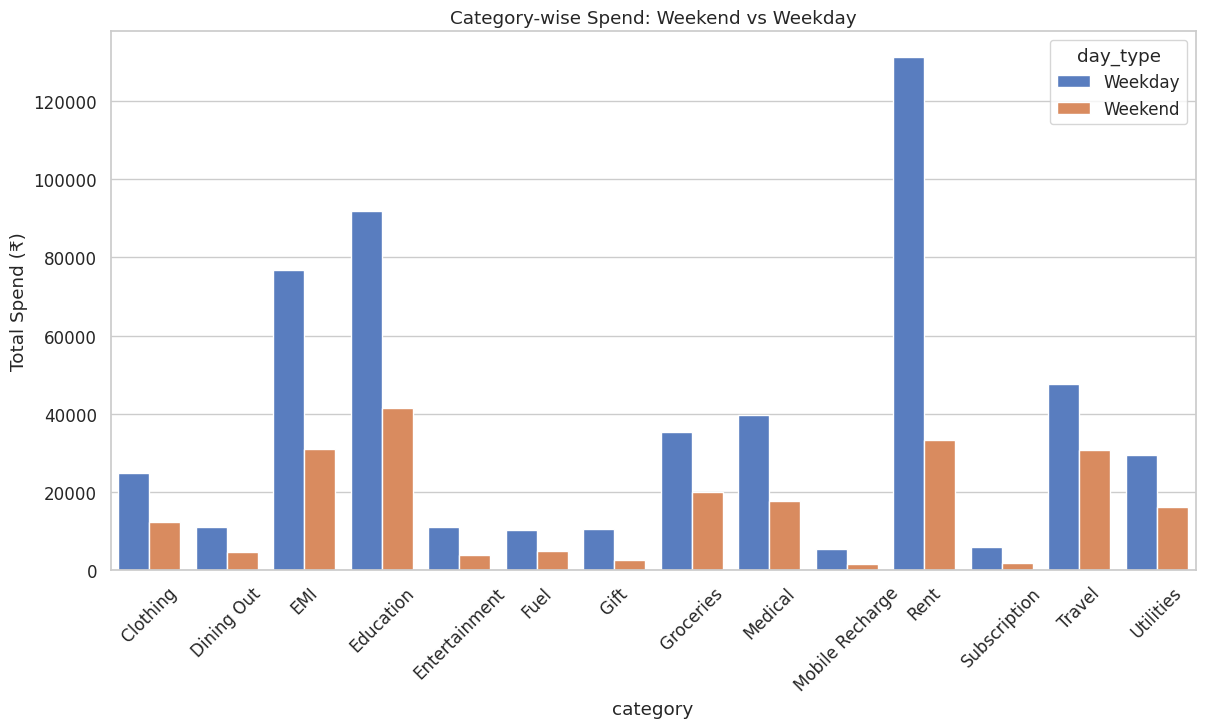

In [63]:
# Average spend and count per day_type
day_type_summary = df.groupby('day_type').agg(
    avg_spend=('value', 'mean'),
    total_spend=('value', 'sum'),
    transaction_count=('value', 'count'),
    leakage_spend=('is_leakage_potential', lambda x: (df.loc[x.index, 'value'] * x).sum()),
    leakage_count=('is_leakage_potential', 'sum')
).reset_index()

print("Spending Summary by Day Type (Weekend vs Weekday):")
print(day_type_summary)

# Category-wise spend on Weekends vs Weekdays
category_daytype = df.groupby(['day_type', 'category']).agg(
    total_spend=('value', 'sum'),
    transaction_count=('value', 'count')
).reset_index()

plt.figure(figsize=(14,7))
sns.barplot(data=category_daytype, x='category', y='total_spend', hue='day_type')
plt.title('Category-wise Spend: Weekend vs Weekday')
plt.xticks(rotation=45)
plt.ylabel('Total Spend (₹)')
plt.show()


2. Festive Months Spending (October, December) -

Goal: Analyze spend volume, category changes, and leakage increases during festivals.

Actions:

Filter data for October and December.

Compare overall spend and category-wise spend during festive months versus other months.

Check proportion of leakage spend.

Total Spend in Festive Months (Oct, Dec): ₹98781
Total Spend in Non-Festive Months: ₹655442


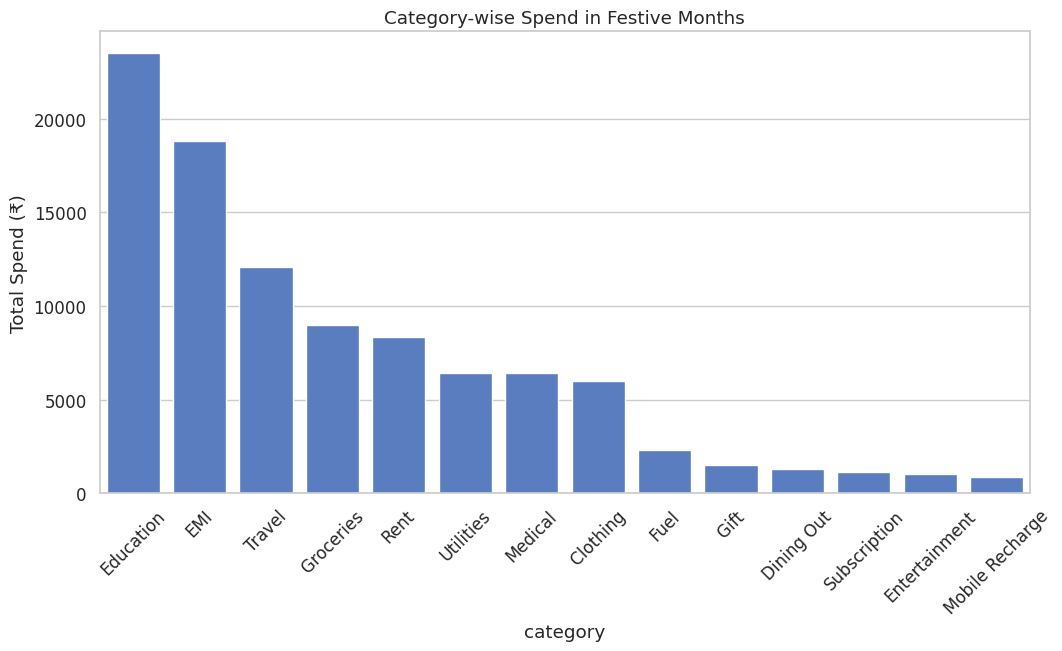

Leakage Spend in Festive Months: ₹16349 (16.55%)


In [64]:
# Filter festive months
festive_months = df[df['month'].isin([10, 12])]

# Overall spend comparison
overall_festive_spend = festive_months['value'].sum()
overall_non_festive_spend = df[~df['month'].isin([10, 12])]['value'].sum()

print(f"Total Spend in Festive Months (Oct, Dec): ₹{overall_festive_spend}")
print(f"Total Spend in Non-Festive Months: ₹{overall_non_festive_spend}")

# Category spend during festive months
festive_cat_spend = festive_months.groupby('category')['value'].sum().reset_index().sort_values(by='value', ascending=False)

plt.figure(figsize=(12,6))
sns.barplot(data=festive_cat_spend, x='category', y='value')
plt.title('Category-wise Spend in Festive Months')
plt.xticks(rotation=45)
plt.ylabel('Total Spend (₹)')
plt.show()

# Leakage spend proportion in festive months
leakage_festive = festive_months[festive_months['is_leakage_potential'] == 1]['value'].sum()
leakage_proportion = leakage_festive / overall_festive_spend * 100

print(f"Leakage Spend in Festive Months: ₹{leakage_festive} ({leakage_proportion:.2f}%)")


3. Summer / Winter Holidays Spending -

Goal: Analyze spend patterns during low-spending months (typically May-June for summer and Dec-Jan for winter holidays in India).

Actions:

Define summer and winter holiday months.

Compare total spends, category-wise breakdown, and leakage during these months vs others.

Summer Holiday Spend: ₹167073, Leakage: ₹42057 (25.17%)
Winter Holiday Spend: ₹126596, Leakage: ₹19894 (15.71%)


([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13],
 [Text(0, 0, 'Clothing'),
  Text(1, 0, 'Dining Out'),
  Text(2, 0, 'EMI'),
  Text(3, 0, 'Education'),
  Text(4, 0, 'Entertainment'),
  Text(5, 0, 'Fuel'),
  Text(6, 0, 'Gift'),
  Text(7, 0, 'Groceries'),
  Text(8, 0, 'Medical'),
  Text(9, 0, 'Mobile Recharge'),
  Text(10, 0, 'Rent'),
  Text(11, 0, 'Subscription'),
  Text(12, 0, 'Travel'),
  Text(13, 0, 'Utilities')])

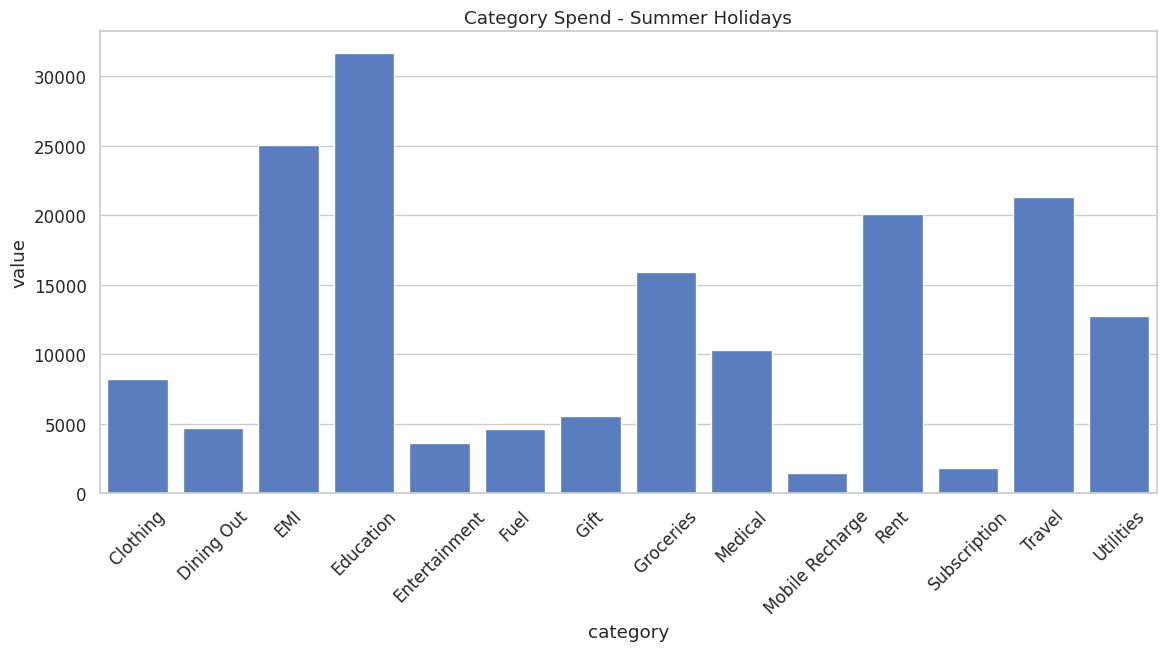

In [65]:
# Define holiday months (adjust as per data)
summer_months = [5, 6]   # May, June
winter_months = [12, 1]  # December, January

summer_spend = df[df['month'].isin(summer_months)]
winter_spend = df[df['month'].isin(winter_months)]

# Calculate spends and leakage proportion for summer
summer_total = summer_spend['value'].sum()
summer_leakage = summer_spend[summer_spend['is_leakage_potential'] == 1]['value'].sum()
summer_leakage_pct = (summer_leakage / summer_total * 100) if summer_total > 0 else 0

# Calculate spends and leakage proportion for winter
winter_total = winter_spend['value'].sum()
winter_leakage = winter_spend[winter_spend['is_leakage_potential'] == 1]['value'].sum()
winter_leakage_pct = (winter_leakage / winter_total * 100) if winter_total > 0 else 0

print(f"Summer Holiday Spend: ₹{summer_total}, Leakage: ₹{summer_leakage} ({summer_leakage_pct:.2f}%)")
print(f"Winter Holiday Spend: ₹{winter_total}, Leakage: ₹{winter_leakage} ({winter_leakage_pct:.2f}%)")

# Category-wise spend in summer vs winter
summer_cat = summer_spend.groupby('category')['value'].sum().reset_index()
winter_cat = winter_spend.groupby('category')['value'].sum().reset_index()

plt.figure(figsize=(30,6))
plt.subplot(1,2,1)
sns.barplot(data=summer_cat, x='category', y='value')
plt.title('Category Spend - Summer Holidays')
plt.xticks(rotation=45)



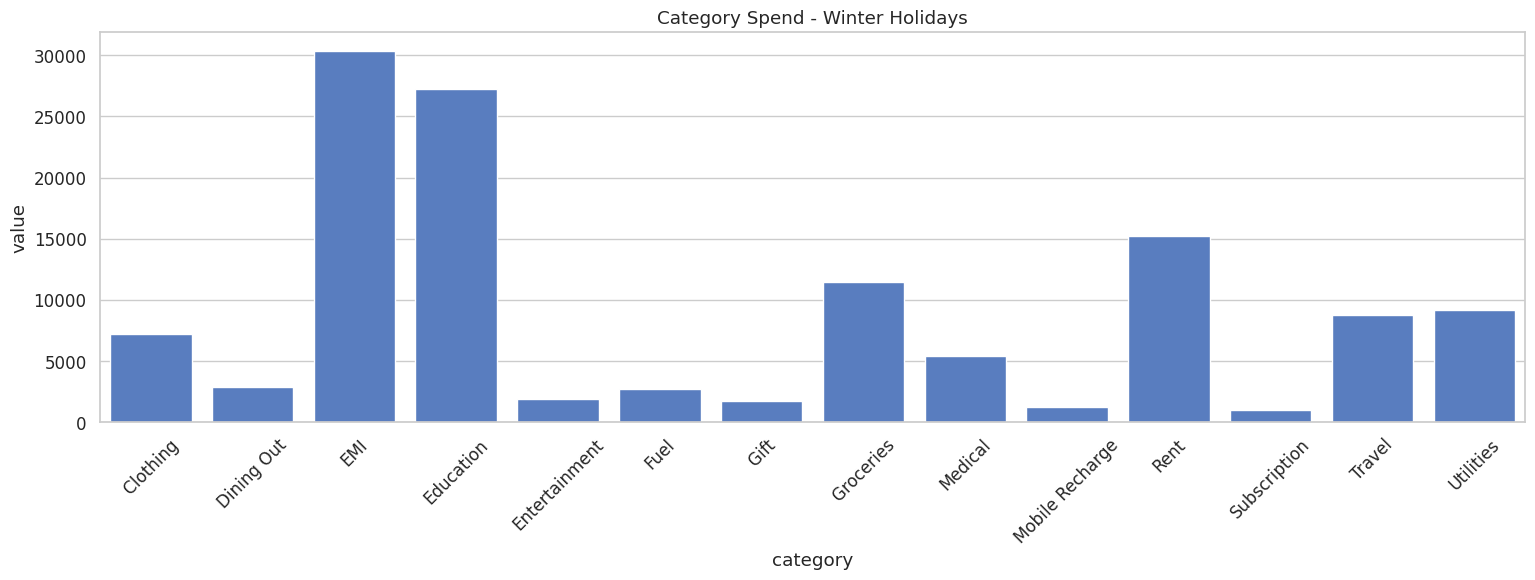

In [66]:
plt.figure(figsize=(30,6))
plt.subplot(1,2,2)
sns.barplot(data=winter_cat, x='category', y='value')
plt.title('Category Spend - Winter Holidays')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


4. Peak Spending Hours and Triggers -

Goal: Find spending spikes by time of day and relate them to leakage and category/context.

Actions:

Aggregate spend by time_block and day_type.

Highlight non-necessary and leakage spends by time block.

Look for spending spikes.

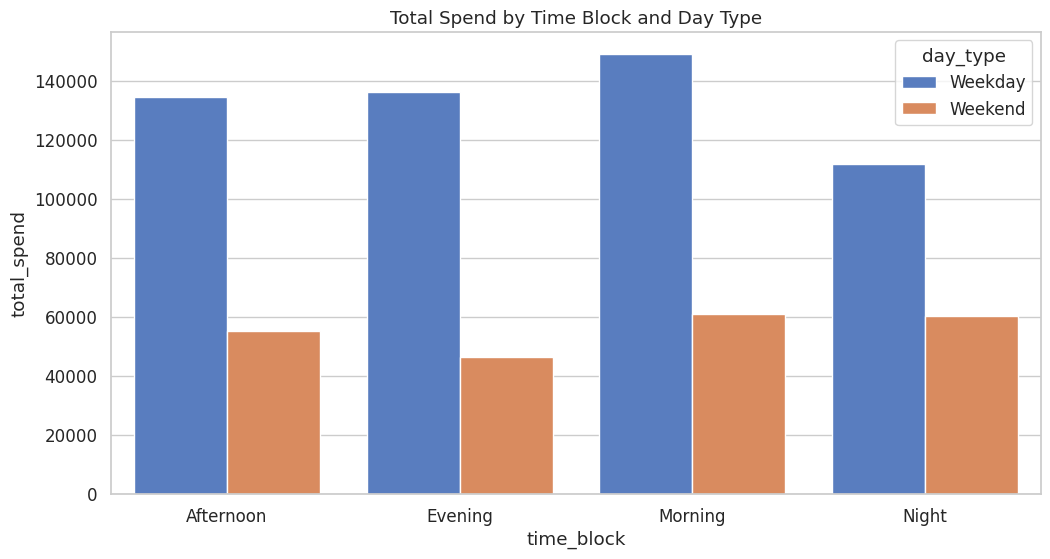

In [67]:
# Spend by time_block and day_type
time_spend = df.groupby(['time_block', 'day_type']).agg(
    total_spend=('value', 'sum'),
    leakage_spend=('is_leakage_potential', lambda x: (df.loc[x.index, 'value'] * x).sum())
).reset_index()

plt.figure(figsize=(12,6))
sns.barplot(data=time_spend, x='time_block', y='total_spend', hue='day_type')
plt.title('Total Spend by Time Block and Day Type')
plt.show()


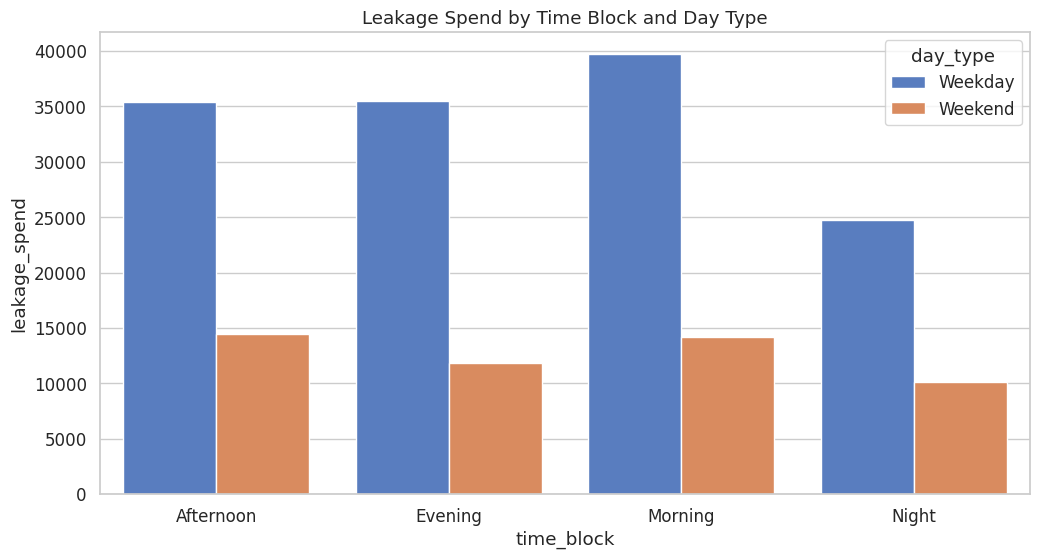

In [68]:
plt.figure(figsize=(12,6))
sns.barplot(data=time_spend, x='time_block', y='leakage_spend', hue='day_type')
plt.title('Leakage Spend by Time Block and Day Type')
plt.show()



In [69]:
# Breakdown leakage spend by category and context during peak time_blocks
peak_time_blocks = time_spend.sort_values('leakage_spend', ascending=False).head(2)['time_block'].tolist()
peak_data = df[(df['time_block'].isin(peak_time_blocks)) & (df['is_leakage_potential'] == 1)]

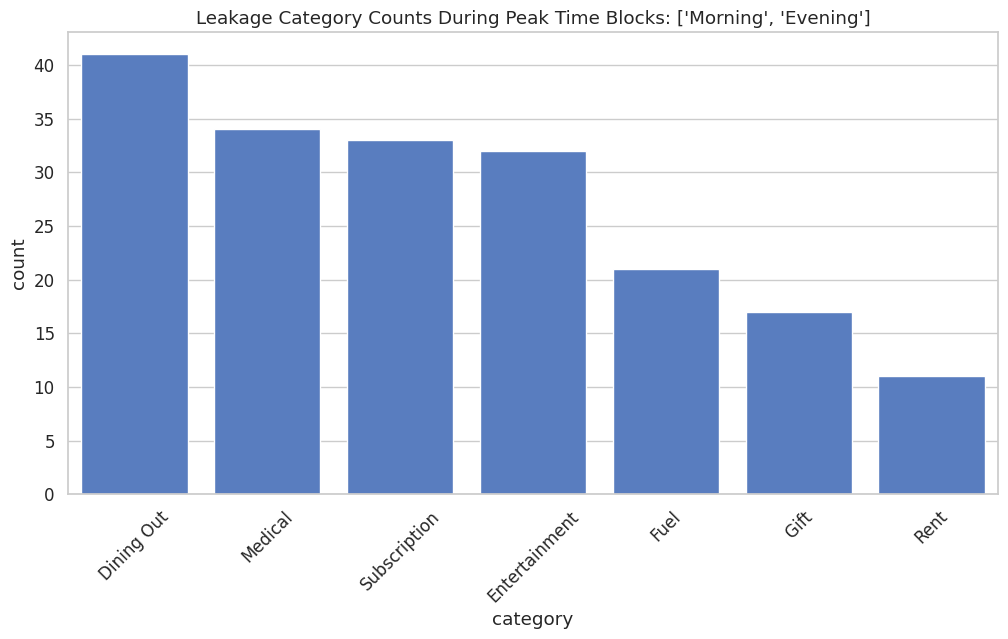

In [70]:
plt.figure(figsize=(12,6))
sns.countplot(data=peak_data, x='category', order=peak_data['category'].value_counts().index)
plt.title(f'Leakage Category Counts During Peak Time Blocks: {peak_time_blocks}')
plt.xticks(rotation=45)
plt.show()


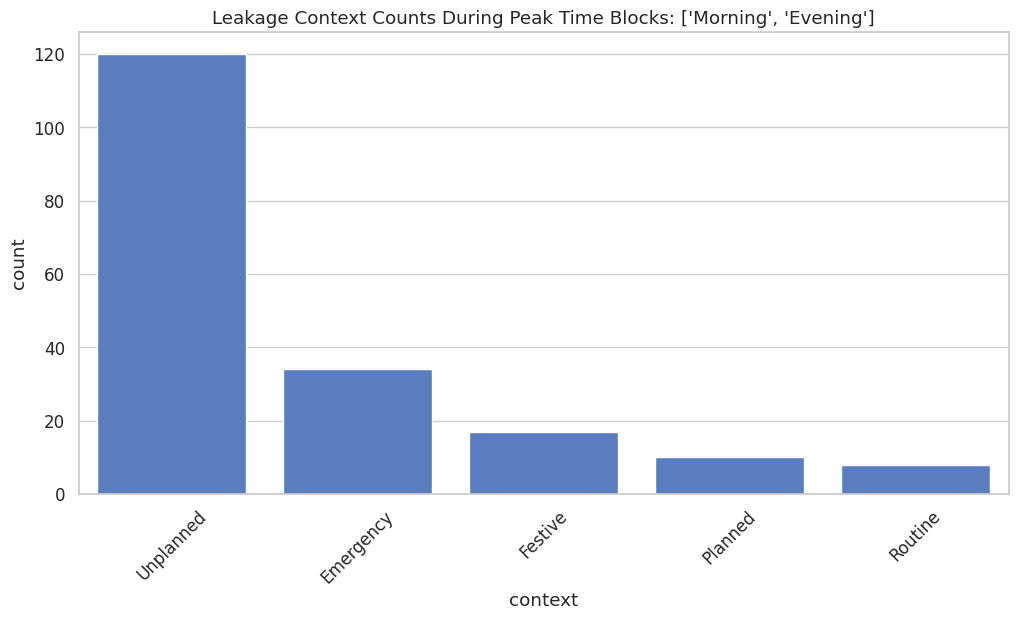

In [71]:

plt.figure(figsize=(12,6))
sns.countplot(data=peak_data, x='context', order=peak_data['context'].value_counts().index)
plt.title(f'Leakage Context Counts During Peak Time Blocks: {peak_time_blocks}')
plt.xticks(rotation=45)
plt.show()

## Leakage Scoring System (Feature Synthesis)

Define the scoring function -

Each transaction is evaluated for leakage potential based on 6 conditions. We'll assign weights as discussed.

In [72]:
def compute_leakage_score(row):
    score = 0
    if row['is_micro_spend']:  # Micro spend (< ₹300)
        score += 1
    if row['Is_Necessary'] == 'No':  # Non-necessary
        score += 2
    if row['context'] in ['Unplanned', 'Emergency', 'Festive']:  # Impulsive contexts
        score += 2
    if row['is_recurring'] == 'Yes' and row['context'] != 'Planned':  # Recurring but unplanned
        score += 2
    if row['time_block'] in ['Evening', 'Night']:  # Impulse-prone time
        score += 1
    if row['day_type'] == 'Weekend':  # Impulse-prone day
        score += 1
    return score

# Apply to dataset
df['leakage_score'] = df.apply(compute_leakage_score, axis=1)

Aggregate Leakage Metrics -

We’ll now use this score to extract insightful summaries.

- Monthly total leakage amount

In [73]:
df['is_leakage'] = df['leakage_score'].apply(lambda x: 1 if x >= 5 else 0)

# Monthly leakage ₹ amount
monthly_leakage_amount = df[df['is_leakage'] == 1].groupby('year_month')['value'].sum().reset_index()
monthly_leakage_amount.columns = ['year_month', 'leakage_amount']

In [74]:
monthly_leakage_amount

,year_month,leakage_amount
0,2023-01,2036
1,2023-02,1662
2,2023-03,6625
3,2023-04,4184
4,2023-05,6050
5,2023-06,8449
6,2023-07,6613
7,2023-08,1964
8,2023-09,5204
9,2023-10,5136


- Leakage % of total monthly spend

In [75]:
monthly_total_spend = df.groupby('year_month')['value'].sum().reset_index()
monthly_total_spend.columns = ['year_month', 'total_spend']

# Merge and calculate % leakage
monthly_leakage_summary = pd.merge(monthly_leakage_amount, monthly_total_spend, on='year_month', how='left')
monthly_leakage_summary['leakage_percent'] = (monthly_leakage_summary['leakage_amount'] / monthly_leakage_summary['total_spend']) * 100

- Top leakage categories (based on spend and count)

In [76]:
# Spend by category (leakages only)
leakage_by_category = df[df['is_leakage'] == 1].groupby('category').agg(
    total_leakage_spend=('value', 'sum'),
    leakage_count=('value', 'count')
).sort_values(by='total_leakage_spend', ascending=False).reset_index()

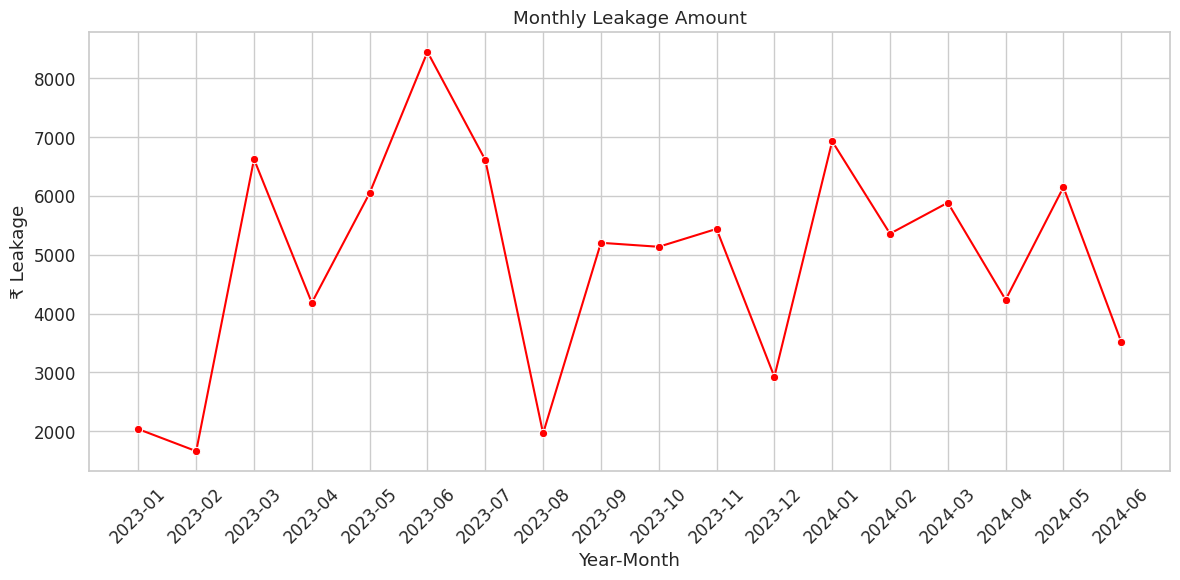

In [77]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

#Fix: Convert year_month to string (safe for plotting categorical x-axis)
monthly_leakage_summary['year_month'] = monthly_leakage_summary['year_month'].astype(str)

# Plot: Monthly Leakage Amount Trend
plt.figure(figsize=(12, 6))
sns.lineplot(
    data=monthly_leakage_summary,
    x='year_month',
    y='leakage_amount',
    marker='o',
    color='red'
)
plt.title('Monthly Leakage Amount')
plt.xlabel('Year-Month')
plt.ylabel('₹ Leakage')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


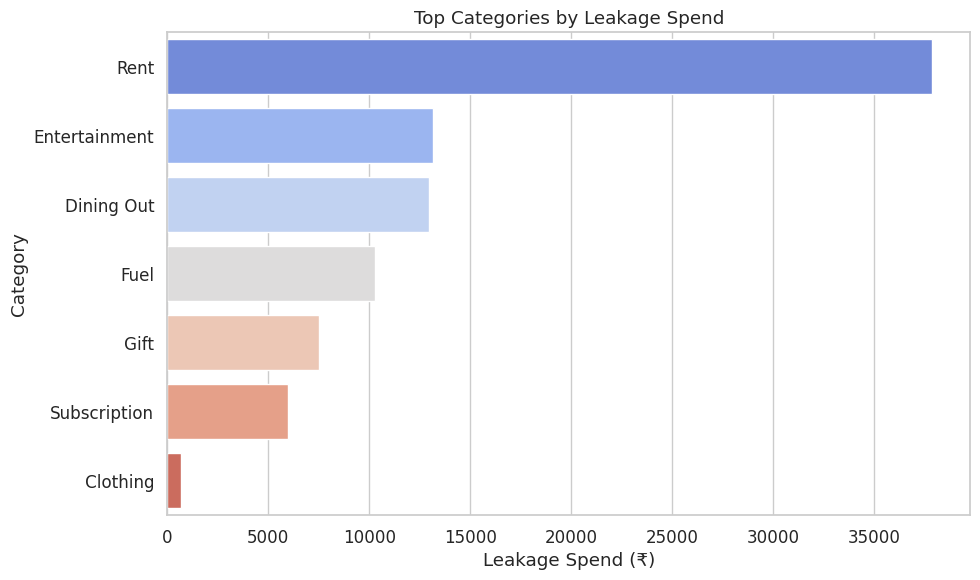

In [78]:
plt.figure(figsize=(10,6))
sns.barplot(data=leakage_by_category, x='total_leakage_spend', y='category', palette='coolwarm')
plt.title('Top Categories by Leakage Spend')
plt.xlabel('Leakage Spend (₹)')
plt.ylabel('Category')
plt.tight_layout()
plt.show()


## MODEL DEVELOPMENT

is_leakage
0    623
1    237
Name: count, dtype: int64


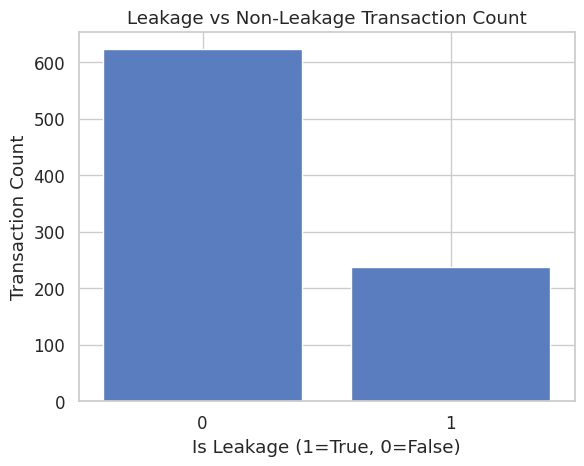

In [79]:

df['is_leakage'] = df['leakage_score'].apply(lambda x: 1 if x >= 5 else 0)

# Optional: Quick class balance check
print(df['is_leakage'].value_counts())
sns.countplot(data=df, x='is_leakage')
plt.title('Leakage vs Non-Leakage Transaction Count')
plt.xlabel('Is Leakage (1=True, 0=False)')
plt.ylabel('Transaction Count')
plt.grid(True)
plt.show()

In [80]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 860 entries, 0 to 859
Data columns (total 31 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   Id                         860 non-null    int64         
 1   Date                       860 non-null    datetime64[ns]
 2   type                       860 non-null    object        
 3   category                   860 non-null    object        
 4   value                      860 non-null    int64         
 5   Is_Necessary               860 non-null    object        
 6   payment_mode               860 non-null    object        
 7   is_recurring               860 non-null    object        
 8   context                    860 non-null    object        
 9   time_block                 860 non-null    object        
 10  day_type                   860 non-null    object        
 11  cummulative monthly spend  860 non-null    float64       
 12  month   

In [81]:
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()

category_dict = {col: df[col].dropna().unique().tolist() for col in categorical_cols}

import pprint
pprint.pprint(category_dict)


{'Is_Necessary': ['Yes', 'No'],
 'category': ['Education',
              'Entertainment',
              'Clothing',
              'Dining Out',
              'Travel',
              'Subscription',
              'Rent',
              'EMI',
              'Groceries',
              'Mobile Recharge',
              'Utilities',
              'Fuel',
              'Medical',
              'Gift'],
 'context': ['Planned',
             'Unplanned',
             'Seasonal',
             'Routine',
             'Emergency',
             'Festive'],
 'day_of_week': ['Sunday',
                 'Monday',
                 'Tuesday',
                 'Wednesday',
                 'Thursday',
                 'Saturday',
                 'Friday'],
 'day_type': ['Weekend', 'Weekday'],
 'is_recurring': ['No', 'Yes'],
 'payment_mode': ['Debit Card', 'Upi', 'Cash', 'Net Banking', 'Credit Card'],
 'time_block': ['Afternoon', 'Morning', 'Night', 'Evening'],
 'type': ['Expense']}


In [82]:
df.to_csv("leakage_dataset_final.csv", index=False)

In [83]:
# Basic packages
import pandas as pd
import numpy as np

# Modeling & Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Evaluation
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

# Explainability
import shap

In [84]:
# Drop unnecessary identifiers and datetime/period columns
df['Date'] = pd.to_datetime(df['Date'])
df.drop(['Id', 'Date', 'year_month'], axis=1, inplace=True)

In [85]:
# Define target and features
X_clean = df.drop("is_leakage", axis=1)
y_clean = df["is_leakage"].astype(int)

In [86]:
# 1. Drop NaNs from X_clean (assuming X_clean and y_clean were already defined)
X_clean = X_clean.dropna()

# 2. Align y to match the filtered X
y_clean = y_clean.loc[X_clean.index]

# 3. Assign to X and y
X = X_clean
y = y_clean

# 4. Now do the train-test split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [87]:
categorical_cols = [
    'type', 'category', 'Is_Necessary', 'payment_mode',
    'is_recurring', 'context', 'time_block', 'day_type', 'day_of_week'
]
numeric_cols = [col for col in X.columns if col not in categorical_cols]

In [88]:
# Column Transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ]
)

In [89]:
# Logistic Regression Pipeline
logreg_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000, class_weight='balanced'))
])

In [90]:
# Random Forest Pipeline
rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=100, class_weight='balanced'))
])


In [91]:
# XGBoost Pipeline
xgb_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(use_label_encoder=False, eval_metric='logloss'))
])

In [92]:
# Model Evaluation Function
def evaluate_model(pipeline, name):
    model = pipeline.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"\n{name} Performance:\n")
    print(classification_report(y_test, y_pred))

    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'{name} Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    try:
        y_proba = model.predict_proba(X_test)[:, 1]
        roc = roc_auc_score(y_test, y_proba)
        print(f"ROC AUC Score: {roc:.4f}")
    except:
        pass
    return model


Logistic Regression Performance:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       125
           1       1.00      1.00      1.00        47

    accuracy                           1.00       172
   macro avg       1.00      1.00      1.00       172
weighted avg       1.00      1.00      1.00       172



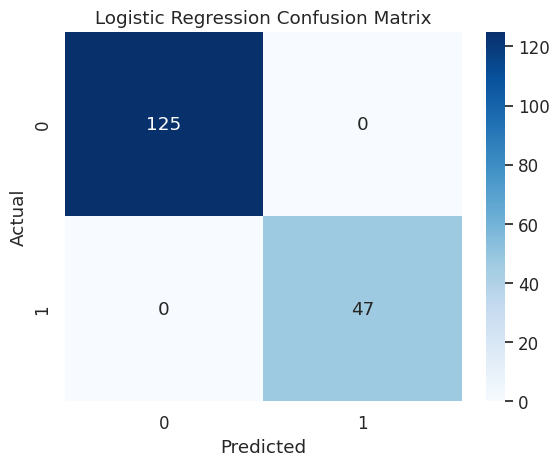

ROC AUC Score: 1.0000


In [93]:
logreg_model = evaluate_model(logreg_pipeline, "Logistic Regression")


Random Forest Performance:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       125
           1       1.00      1.00      1.00        47

    accuracy                           1.00       172
   macro avg       1.00      1.00      1.00       172
weighted avg       1.00      1.00      1.00       172



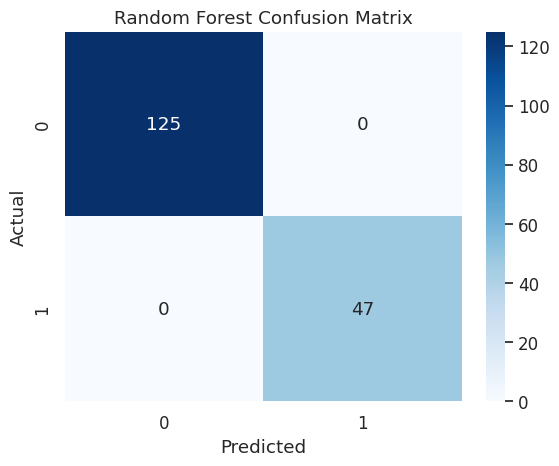

ROC AUC Score: 1.0000


In [94]:
rf_model = evaluate_model(rf_pipeline, "Random Forest")


XGBoost Performance:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       125
           1       1.00      1.00      1.00        47

    accuracy                           1.00       172
   macro avg       1.00      1.00      1.00       172
weighted avg       1.00      1.00      1.00       172



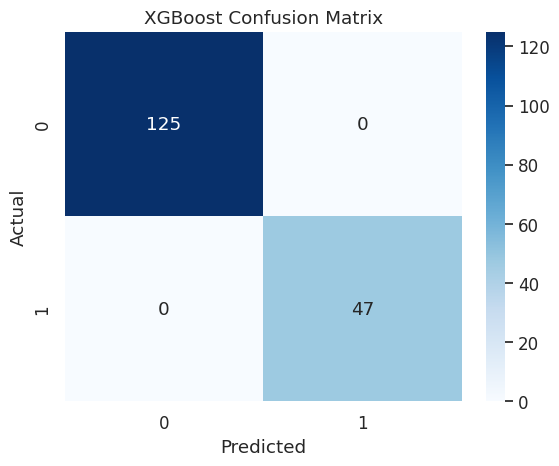

ROC AUC Score: 1.0000


In [95]:
xgb_model = evaluate_model(xgb_pipeline, "XGBoost")

In [96]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

models = {
    "LogisticRegression": logreg_pipeline,
    "RandomForest": rf_pipeline,
    "XGBoost": xgb_pipeline
}

results = []
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    results.append({
        "Model": name,
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1 Score": f1_score(y_test, y_pred),
        "ROC AUC": roc_auc_score(y_test, y_proba)
    })

results_df = pd.DataFrame(results)
results_df.sort_values("F1 Score", ascending=False)


,Model,Accuracy,Precision,Recall,F1 Score,ROC AUC
0,LogisticRegression,1.0,1.0,1.0,1.0,1.0
1,RandomForest,1.0,1.0,1.0,1.0,1.0
2,XGBoost,1.0,1.0,1.0,1.0,1.0


In [97]:
from sklearn.model_selection import GridSearchCV

# Random Forest
rf_grid = {
    'classifier__n_estimators': [50, 100],
    'classifier__max_depth': [5, 10, None],
    'classifier__min_samples_split': [2, 5],
}
rf_search = GridSearchCV(rf_pipeline, rf_grid, cv=3, scoring='f1', n_jobs=-1)
rf_search.fit(X_train, y_train)

# Best RF
print("Best Random Forest Params:", rf_search.best_params_)
print("Best RF F1 Score:", rf_search.best_score_)

# XGBoost
xgb_grid = {
    'classifier__n_estimators': [50, 100],
    'classifier__max_depth': [3, 6, 10],
    'classifier__learning_rate': [0.01, 0.1]
}
xgb_search = GridSearchCV(xgb_pipeline, xgb_grid, cv=3, scoring='f1', n_jobs=-1)
xgb_search.fit(X_train, y_train)

# Best XGBoost
print("Best XGB Params:", xgb_search.best_params_)
print("Best XGB F1 Score:", xgb_search.best_score_)


Best Random Forest Params: {'classifier__max_depth': 5, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 100}
Best RF F1 Score: 1.0
Best XGB Params: {'classifier__learning_rate': 0.01, 'classifier__max_depth': 3, 'classifier__n_estimators': 50}
Best XGB F1 Score: 1.0


In [98]:
import joblib

# Save the best model
joblib.dump(rf_search.best_estimator_, 'best_rf_model.pkl')

# Load later
model_loaded = joblib.load('best_rf_model.pkl')
preds = model_loaded.predict(X_test)


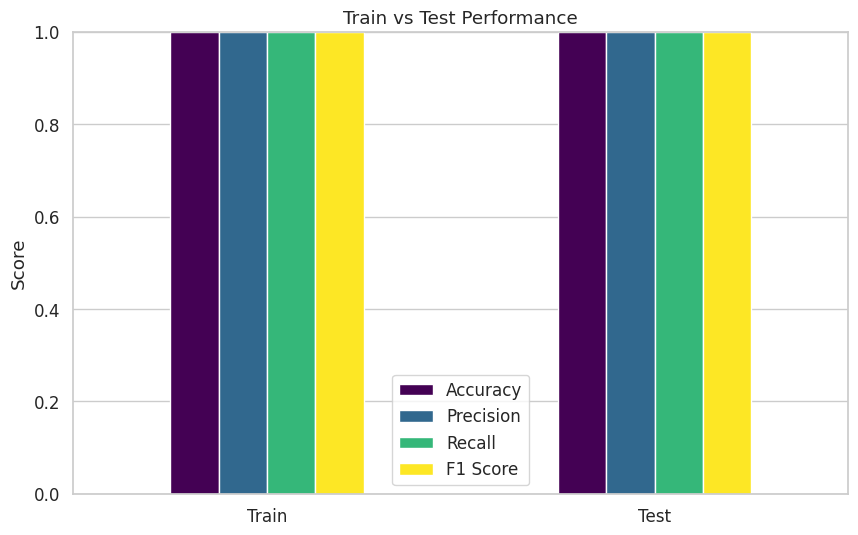

In [99]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def evaluate_overfitting(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)

    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    metrics = {
        'Accuracy': [accuracy_score(y_train, y_train_pred), accuracy_score(y_test, y_test_pred)],
        'Precision': [precision_score(y_train, y_train_pred), precision_score(y_test, y_test_pred)],
        'Recall': [recall_score(y_train, y_train_pred), recall_score(y_test, y_test_pred)],
        'F1 Score': [f1_score(y_train, y_train_pred), f1_score(y_test, y_test_pred)]
    }

    df_metrics = pd.DataFrame(metrics, index=['Train', 'Test'])
    df_metrics.plot(kind='bar', figsize=(10, 6), colormap='viridis', ylim=(0, 1))
    plt.title("Train vs Test Performance")
    plt.ylabel("Score")
    plt.grid(True)
    plt.xticks(rotation=0)
    plt.show()

# Example usage
evaluate_overfitting(rf_pipeline, X_train, X_test, y_train, y_test)


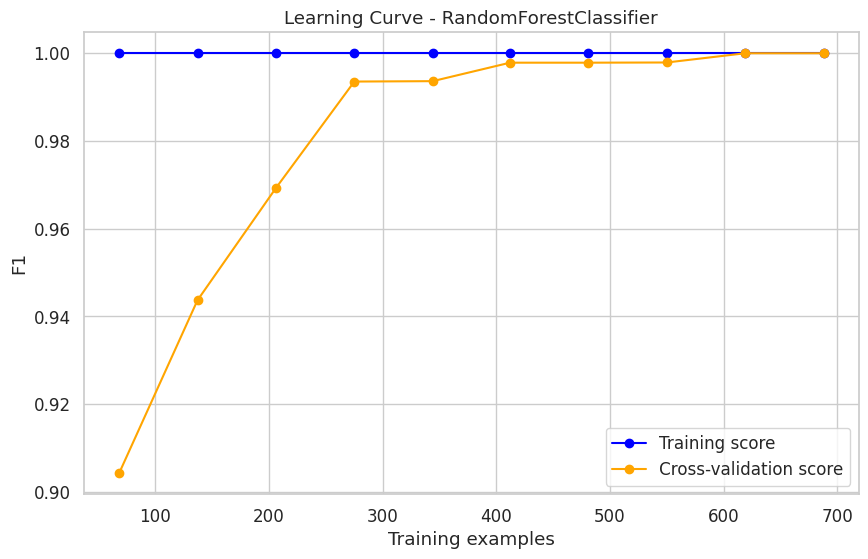

In [100]:
from sklearn.model_selection import learning_curve

def plot_learning_curve(estimator, X, y, cv=5, scoring='f1'):
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, scoring=scoring,
        n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10), random_state=42
    )

    train_scores_mean = train_scores.mean(axis=1)
    test_scores_mean = test_scores.mean(axis=1)

    plt.figure(figsize=(10,6))
    plt.plot(train_sizes, train_scores_mean, 'o-', label="Training score", color="blue")
    plt.plot(train_sizes, test_scores_mean, 'o-', label="Cross-validation score", color="orange")
    plt.title(f"Learning Curve - {estimator.named_steps['classifier'].__class__.__name__}")
    plt.xlabel("Training examples")
    plt.ylabel(scoring.capitalize())
    plt.legend(loc="best")
    plt.grid(True)
    plt.show()

# Use raw X and y
plot_learning_curve(rf_pipeline, X, y, scoring='f1')


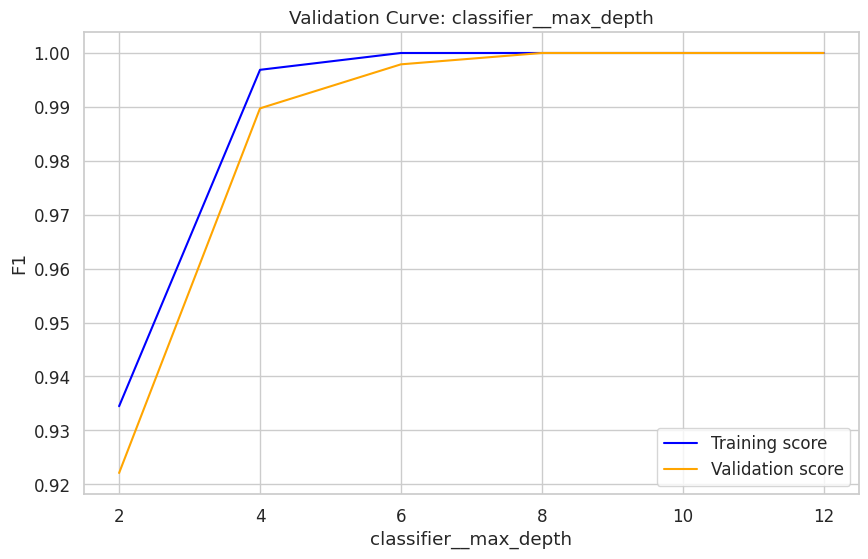

In [101]:
from sklearn.model_selection import validation_curve

def plot_validation_curve(estimator, X, y, param_name, param_range, scoring='f1'):
    train_scores, test_scores = validation_curve(
        estimator, X, y,
        param_name=param_name,
        param_range=param_range,
        scoring=scoring,
        cv=5, n_jobs=-1
    )

    train_mean = np.mean(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)

    plt.figure(figsize=(10,6))
    plt.plot(param_range, train_mean, label='Training score', color='blue')
    plt.plot(param_range, test_mean, label='Validation score', color='orange')
    plt.title(f'Validation Curve: {param_name}')
    plt.xlabel(param_name)
    plt.ylabel(scoring.capitalize())
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()

# Example usage for RF
plot_validation_curve(rf_pipeline, X, y, 'classifier__max_depth', [2, 4, 6, 8, 10, 12, None])


## Manual Input Value



In [102]:
import pandas as pd

# Sample input - You can edit values here
manual_input = {
    'type': 'Expense',
    'category': 'Dining Out',
    'value': 350,
    'Is_Necessary': 'No',
    'payment_mode': 'Upi',
    'is_recurring': 'No',
    'context': 'Unplanned',
    'time_block': 'Evening',
    'day_type': 'Weekday',
    'cummulative monthly spend': 12000.50,
    'month': 6,
    'year': 2025,
    'day_of_week': 'Friday',
    'week_of_month': 2,
    'is_salary_week': False,
    'is_micro_spend': 1,
    'is_leakage_potential': 1,
    'monthly_total_spend': 62000,
    'monthly_non_essential_pct': 0.56,
    'avg_spend_per_time_block': 432.5,
    'avg_spend_per_day_type': 720.3,
    'cumulative_monthly_spend': 18500,
    'daily_spend': 1250,
    'monthly_category_spend': 3200,
    'category_spend_ratio': 0.08,
    'recurring_expense_count': 3,
    'leakage_score': 7
}

# Convert to DataFrame (1-row)
manual_df = pd.DataFrame([manual_input])


In [103]:
df

,type,category,value,Is_Necessary,payment_mode,is_recurring,context,time_block,day_type,cummulative monthly spend,...,monthly_non_essential_pct,avg_spend_per_time_block,avg_spend_per_day_type,cumulative_monthly_spend,daily_spend,monthly_category_spend,category_spend_ratio,recurring_expense_count,leakage_score,is_leakage
0,Expense,Education,1217,Yes,Debit Card,No,Planned,Afternoon,Weekend,1217.0,...,0.198479,870.458716,869.910156,1217,1742,4577,0.155368,17,1,0
1,Expense,Education,525,Yes,Debit Card,No,Planned,Morning,Weekend,1742.0,...,0.198479,893.663830,869.910156,1742,1742,4577,0.155368,17,1,0
2,Expense,Entertainment,194,No,Upi,No,Unplanned,Morning,Weekday,1936.0,...,0.198479,893.663830,880.009934,1936,553,742,0.025188,17,5,1
3,Expense,Clothing,208,No,Cash,No,Seasonal,Morning,Weekday,2144.0,...,0.198479,893.663830,880.009934,2144,553,822,0.027903,17,3,0
4,Expense,Dining Out,151,No,Upi,No,Unplanned,Afternoon,Weekday,2295.0,...,0.198479,870.458716,880.009934,2295,553,502,0.017041,17,5,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
855,Expense,Rent,2619,Yes,Debit Card,Yes,Routine,Evening,Weekday,23806.0,...,0.250973,868.809524,880.009934,23806,7097,6803,0.230197,7,3,0
856,Expense,Rent,2540,Yes,Cash,Yes,Planned,Morning,Weekday,26346.0,...,0.250973,893.663830,880.009934,26346,7097,6803,0.230197,7,0,0
857,Expense,Dining Out,192,No,Net Banking,No,Unplanned,Morning,Weekday,26538.0,...,0.250973,893.663830,880.009934,26538,1409,967,0.032721,7,5,1
858,Expense,Travel,1217,No,Credit Card,No,Seasonal,Evening,Weekday,27755.0,...,0.250973,868.809524,880.009934,27755,1409,4697,0.158935,7,3,0


In [104]:
# Make prediction
pred_class = rf_pipeline.predict(manual_df)[0]
pred_proba = rf_pipeline.predict_proba(manual_df)[0][1]

print(f"Prediction: {'Leakage' if pred_class else 'Not Leakage'}")
print(f"Probability of Leakage: {pred_proba:.2%}")


Prediction: Leakage
Probability of Leakage: 76.00%


In [105]:
manual_input = {
    'type': 'Expense',
    'category': 'Groceries',
    'value': 1200,
    'Is_Necessary': 'Yes',
    'payment_mode': 'Debit Card',
    'is_recurring': 'Yes',
    'context': 'Routine',
    'time_block': 'Morning',
    'day_type': 'Weekday',
    'cummulative monthly spend': 18500.75,
    'month': 6,
    'year': 2025,
    'day_of_week': 'Wednesday',
    'week_of_month': 2,
    'is_salary_week': True,
    'is_micro_spend': 0,
    'is_leakage_potential': 0,
    'monthly_total_spend': 55000,
    'monthly_non_essential_pct': 0.22,
    'avg_spend_per_time_block': 650.0,
    'avg_spend_per_day_type': 890.4,
    'cumulative_monthly_spend': 14500,
    'daily_spend': 950,
    'monthly_category_spend': 8800,
    'category_spend_ratio': 0.16,
    'recurring_expense_count': 5,
    'leakage_score': 2
}

# Convert to DataFrame
manual_df_2 = pd.DataFrame([manual_input])

# Predict using pipeline
pred_class_2 = rf_pipeline.predict(manual_df_2)[0]
pred_proba_2 = rf_pipeline.predict_proba(manual_df_2)[0][1]

print(f"Prediction: {'Leakage' if pred_class_2 else 'Not Leakage'}")
print(f"Probability of Leakage: {pred_proba_2:.2%}")


Prediction: Not Leakage
Probability of Leakage: 0.00%


## Questions as Queries

In [106]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 860 entries, 0 to 859
Data columns (total 28 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   type                       860 non-null    object 
 1   category                   860 non-null    object 
 2   value                      860 non-null    int64  
 3   Is_Necessary               860 non-null    object 
 4   payment_mode               860 non-null    object 
 5   is_recurring               860 non-null    object 
 6   context                    860 non-null    object 
 7   time_block                 860 non-null    object 
 8   day_type                   860 non-null    object 
 9   cummulative monthly spend  860 non-null    float64
 10  month                      860 non-null    int32  
 11  year                       860 non-null    int32  
 12  day_of_week                860 non-null    object 
 13  week_of_month              860 non-null    int64  

In [107]:
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()

category_dict = {col: df[col].dropna().unique().tolist() for col in categorical_cols}

import pprint
pprint.pprint(category_dict)


{'Is_Necessary': ['Yes', 'No'],
 'category': ['Education',
              'Entertainment',
              'Clothing',
              'Dining Out',
              'Travel',
              'Subscription',
              'Rent',
              'EMI',
              'Groceries',
              'Mobile Recharge',
              'Utilities',
              'Fuel',
              'Medical',
              'Gift'],
 'context': ['Planned',
             'Unplanned',
             'Seasonal',
             'Routine',
             'Emergency',
             'Festive'],
 'day_of_week': ['Sunday',
                 'Monday',
                 'Tuesday',
                 'Wednesday',
                 'Thursday',
                 'Saturday',
                 'Friday'],
 'day_type': ['Weekend', 'Weekday'],
 'is_recurring': ['No', 'Yes'],
 'payment_mode': ['Debit Card', 'Upi', 'Cash', 'Net Banking', 'Credit Card'],
 'time_block': ['Afternoon', 'Morning', 'Night', 'Evening'],
 'type': ['Expense']}


## Exporting to Local drive for further analysis in SQL

In [108]:
from google.colab import files

# Save your DataFrame to a CSV
df.to_csv('Final_personal_spending_dataset.csv', index=False)